Assume we want to observe the amplitudes A and B of an oscillation that relates to our observations in the form
$$y = A\sin(t) + B\cos(t)$$
Our instrument collects information every second, whereas only on reading i available. Those measurements refer to the full second. However, we assume that we have some a-priori information on $A$ and $B$ and their covariance.

In [149]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

# the true amplitudes of the sine and cosine terms are given here
A_true = 50
B_true = -25

#observation noise (see text above)
obsnoise1 = 9

#we can build the weight matrix with that info
P=inv(np.matrix([[obsnoise1*obsnoise1]]))

We define the Jacobian as

In [150]:
def GetJacobian(t):
    return np.matrix([[np.sin(t), np.cos(t)]])

And we create a function that provides us "measurements", including some Gaussian noise in accordance to the specifications above

In [151]:
def GetObs(t):
    return np.array([[A_true * np.sin(t) + B_true*np.cos(t)+obsnoise1*np.random.randn()]])

Let's start with the classical LSQ solution at the first epoch (t=0)

In [152]:
#some arrays which we use later for plotting
MM=4000

time_array=np.arange(0,MM)
A_array=np.zeros(MM) 
B_array=np.zeros(MM) 
sigmaA=np.zeros(MM) 
sigmaB=np.zeros(MM) 



x=np.array([[-50],[50]])
s02=1000
Sxx=s02*np.matrix([[1, 0], [0,1]])

#store the results in the first array element
time_array[0]=0
A_array[0]=x[0]
B_array[0]=x[1]
sigmaA[0]=np.sqrt(Sxx[0,0])
sigmaB[0]=np.sqrt(Sxx[1,1])

Now we are ready to run the sequential least-squares method over an observation period 

In [153]:
for t in np.arange(2,MM):
    #storing the "old" states and variances
    x_old=x
    s02_old=s02
    Sxx_old=Sxx
    
 
    #processing the observations at t_k
    A=GetJacobian(t/100)
    y=GetObs(t/100)
    
    x=x_old + inv(s02_old * inv(Sxx_old) + np.transpose(A)@P@A)@np.transpose(A)@P@(y-A@x_old)
    dx=x-x_old
    epsi=y-A@x
    s02 = np.asscalar(1.0/((t+1)-2.0)*( s02_old * (t-1 + np.transpose(dx)@inv(Sxx_old)@dx) + np.transpose(epsi)@P@epsi))
    Sxx=s02*inv(s02_old*inv(Sxx_old) + np.transpose(A)@P@A)
    
    #storing the solution in the array which we will later use for plotting
    time_array[t]=t
    A_array[t]=x[0]
    B_array[t]=x[1]
    sigmaA[t]=np.sqrt(Sxx[0,0])
    sigmaB[t]=np.sqrt(Sxx[1,1])
    

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  from ipykernel import kernelapp as app


Now we can plot the time evolutions of both, out parameters $A$ and $B$ as well as their formal errros.

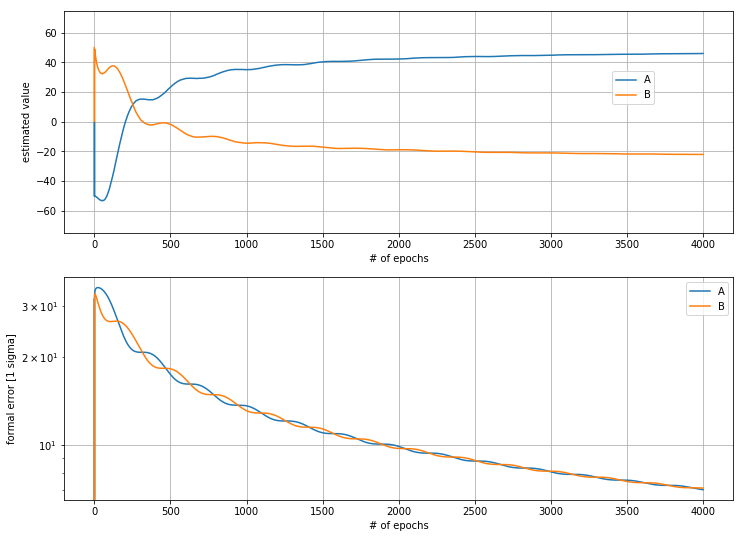

In [154]:
plt.figure(1,figsize=(12, 9))
ax=plt.subplot(211)    
plt.plot(time_array, A_array,label='A')
plt.plot(time_array, B_array,label='B')
ax.legend(loc='upper center', bbox_to_anchor=(0.85, 0.75))
axes = plt.gca()
axes.set_ylim([-75,75])
plt.grid()
plt.xlabel('# of epochs')
plt.ylabel('estimated value')
plt.subplot(212)  
plt.semilogy(time_array, sigmaA,label='A')
plt.semilogy(time_array, sigmaB,label='B')
plt.legend()
plt.grid()
plt.xlabel('# of epochs')
plt.ylabel('formal error [1 sigma]')
plt.show()

What we see is that not only the values of $A$ and $B$ come closer to their "true" values as we collect more observations, but also the formal errors shrink continuously. While this example demonstrates that we can easily perform sequential least-square solutions, it also shows us the large restrications we suffer from this, namely that the parameters need to be constant over time in order to make the algorithm work.